<a href="https://colab.research.google.com/github/eightTT/temp/blob/main/GnnSAGE_hyperparameter_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tools:  
Google Colab (with GPU)  
PyTorch Geometric (PyG) for pre-built GraphSAGE  
Optuna for hyperparameter optimization  

Step:  
Environment Setup	1 Hour  
Dataset Loading	1 Hour  
Model Implementation	1 Hour  
Training and Testing	2 Hours  
Hyperparameter Tuning	4-5 Hours  
Documentation	4-6 Hours  

In [ ]:
# Step 1: Set Up the Environment
# Install necessary libraries
# Install PyTorch Geometric and its dependencies
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch torchvision torchaudio torch-geometric
# !pip install pyg-lib torch-scatter torch-sparse torch-geometric
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu121.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Load the Dataset CORA
dataset_path = '/content/drive/MyDrive/CORA'

dataset = Planetoid(root=dataset_path, name='CORA')
data = dataset[0]

# Dataset Information
print(f"Dataset: {dataset}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Node features shape: {data.x.shape}")

Dataset: CORA()
Number of classes: 7
Number of features: 1433
Number of nodes: 2708
Number of edges: 10556
Edge index shape: torch.Size([2, 10556])
Node features shape: torch.Size([2708, 1433])


Dataset: CORA()  
Number of classes: 7  
Number of features: 1433  
Number of nodes: 2708  
Number of edges: 10556  

In [ ]:
# from torch_geometric.loader import NeighborLoader
# from torch_geometric.utils import to_networkx

# # Create batches with neighbor sampling
# train_loader = NeighborLoader(
#     data,
#     num_neighbors=[5, 10],
#     batch_size=16,
#     input_nodes=data.train_mask,
# )

# # Print each subgraph
# for i, subgraph in enumerate(train_loader):
#     print(f'Subgraph {i}: {subgraph}')

# # Plot each subgraph
# fig = plt.figure(figsize=(16,16))
# for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
#     G = to_networkx(subdata, to_undirected=True)
#     ax = fig.add_subplot(pos)
#     ax.set_title(f'Subgraph {idx}')
#     plt.axis('off')
#     nx.draw_networkx(G,
#                     pos=nx.spring_layout(G, seed=0),
#                     with_labels=True,
#                     node_size=200,
#                     node_color=subdata.y,
#                     cmap="cool",
#                     font_size=10
#                     )
# plt.show()

In [ ]:
# import torch
# print(torch.__version__)

# from torch_geometric.loader import NeighborLoader
# from torch_geometric.utils import to_networkx
# import networkx as nx
# import matplotlib.pyplot as plt

2.5.1+cu121


In [ ]:
# Step 3: Define the GraphSAGE Model
from torch.nn import Module, Linear

class GraphSAGE(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.lin = Linear(out_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)     # agg features from immediate neighbors.
        x = F.relu(x)                     # add non-linearity
        x = F.dropout(x, training=self.training)    #prevent overfitting
        x = self.conv2(x, edge_index)               #agg features further
        return F.log_softmax(self.lin(x), dim=1)    #map to output class


model = GraphSAGE(dataset.num_features, 16, 16)
print(model)
# uses a pre-built layer called SAGEConv from PyTorch Geometric.
# dataset.num_features: Number of features in the dataset (input size).
# 16: Hidden layer size .
# 16: Output size of the second layer .


GraphSAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (lin): Linear(in_features=16, out_features=7, bias=True)
)


**II. Train and Evaluation**




In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # clear gradients from the previous step (avoid accummulate)
    out = model(data.x, data.edge_index)  # Forward pass: Compute predictions
    #data.x: nodes fts
    #data.edges_i: graph structure (connectivity)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # negativ log-likelyhood
    loss.backward()  # Backpropagation: Compute gradients
    optimizer.step()  # Update model parameters
    return loss.item()

# Testing loop
def test():
    model.eval()
    out = model(data.x, data.edge_index)  # Forward pass
    pred = out.argmax(dim=1)  # Predicted class for each node

    # Accuracy on train, validation, and test masks

    accs = []   # store accuracy for each data split
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs


In [ ]:
losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
total_epochs = 100

for epoch in range(total_epochs):
    loss = train()
    train_acc, val_acc, test_acc = test()
    losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch: 001, Loss: 1.9566, Train Acc: 0.2286, Val Acc: 0.3480, Test Acc: 0.3550
Epoch: 002, Loss: 1.8913, Train Acc: 0.6071, Val Acc: 0.4280, Test Acc: 0.4670
Epoch: 003, Loss: 1.7904, Train Acc: 0.7786, Val Acc: 0.5300, Test Acc: 0.5660
Epoch: 004, Loss: 1.6568, Train Acc: 0.8786, Val Acc: 0.5980, Test Acc: 0.6280
Epoch: 005, Loss: 1.4433, Train Acc: 0.9571, Val Acc: 0.6580, Test Acc: 0.6890
Epoch: 006, Loss: 1.2553, Train Acc: 0.9714, Val Acc: 0.6880, Test Acc: 0.7210
Epoch: 007, Loss: 1.0300, Train Acc: 0.9857, Val Acc: 0.6960, Test Acc: 0.7320
Epoch: 008, Loss: 0.8775, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.7230
Epoch: 009, Loss: 0.7435, Train Acc: 0.9857, Val Acc: 0.6760, Test Acc: 0.7210
Epoch: 010, Loss: 0.6099, Train Acc: 0.9929, Val Acc: 0.6760, Test Acc: 0.7070
Epoch: 011, Loss: 0.5027, Train Acc: 0.9929, Val Acc: 0.6780, Test Acc: 0.7070
Epoch: 012, Loss: 0.3723, Train Acc: 0.9929, Val Acc: 0.6680, Test Acc: 0.7040
Epoch: 013, Loss: 0.2687, Train Acc: 0.9929, Val Acc

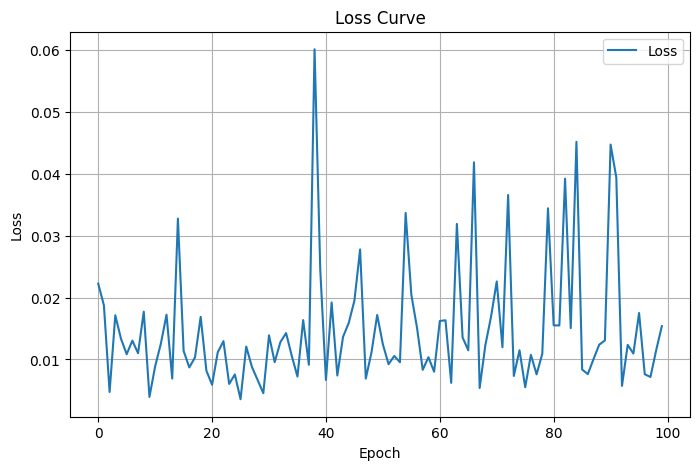

In [ ]:
import matplotlib.pyplot as plt
# loss curve
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()


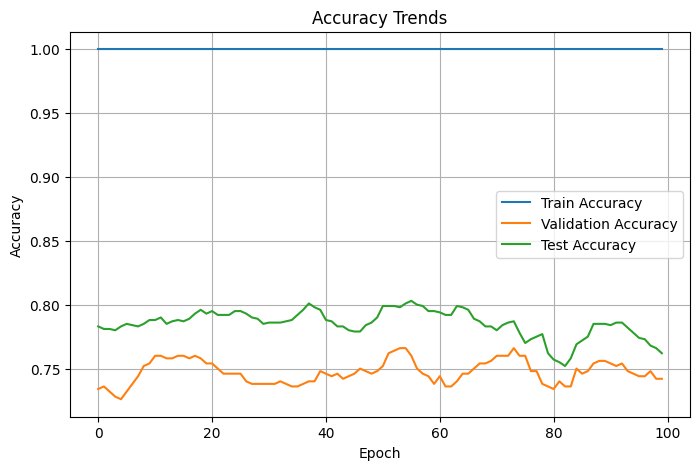

In [ ]:
# accuracy trends
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Trends")
plt.legend()
plt.grid()
plt.show()


**III. Hyperparameter Tuning**

5 hyper-params: Learning Rate, Hidden Layer Size, Dropout Rate, N of layers, Epochs

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import torch

# search space
param_space = {
    "learning_rate": (1e-4, 1e-2),  # Learning Rate
    "weight_decay": (1e-6, 1e-4),
    "hidden_channels": [16, 32, 64],  # Hidden Layer Size
    "dropout_rate": (0.1, 0.3 ),  # Dropout Rate
    # "num_layers": [2, 3],  # Number of Layers
    "epochs": [100, 150, 200]  # Epochs
}

In [ ]:
import time
from sklearn.metrics import f1_score

def objective_function(params):
    """
    Objective function for Bayesian Optimization.
    Args:
        params: List of hyperparameters [learning_rate, weight_decay, hidden_channels, dropout_rate, num_layers, epochs].
    Returns:
        Validation accuracy as the performance metric.
        consider add computational cost as well.
    """

    learning_rate, weight_decay, hidden_channels, dropout_rate, epochs = params

    # Define the model with dynamic hyperparameters
    model = GraphSAGE(dataset.num_features, hidden_channels, hidden_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Measure training time
    start_time = time.time()


    # Training loop
    for epoch in range(int(epochs)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # Forward pass
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute loss
        loss.backward()
        optimizer.step()

    training_time = time.time() - start_time

    # Validation accuracy
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Predicted class for each node

    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_accuracy = int(correct) / int(data.val_mask.sum())

    #F1-score
    val_f1 = f1_score(
        data.y[data.val_mask].cpu().numpy(),
        pred[data.val_mask].cpu().numpy(),
        average="macro"
    )

    # Composite metric: maximize accuracy and F1, penalize training time
    composite_metric = val_accuracy + val_f1 - 0.01 * training_time

    return val_accuracy, composite_metric


In [ ]:
def random_sample(param_space):
  """
  Helper function: sample random hyperparameters
  """
  sample = [
      np.random.uniform(*param_space["learning_rate"]),
      np.random.uniform(*param_space["weight_decay"]),
      np.random.choice(param_space["hidden_channels"]),
      np.random.uniform(*param_space["dropout_rate"]),
      # np.random.choice(param_space["num_layers"]),
      np.random.choice(param_space["epochs"]),
  ]
  return sample

x = random_sample( param_space)
print('random sample:',x)

random sample: [0.008499543356359093, 4.848130134752154e-05, 64, 0.21723728903699663, 100]


In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gpr, xi=0.05):
    """
    Compute Expected Improvement (EI) at point x based on the Gaussian Process model.
    Args:
        x: The hyperparameter combination to evaluate (numpy array).
        gpr: Trained Gaussian Process model.
        xi: Exploration parameter (higher = more exploration).
    Returns:
        EI value.
    """
    x = np.expand_dims(x, axis=0)  # Ensure correct shape
    mean, std = gpr.predict(x, return_std=True)
    best_y = max(y) if y else 0  # Best observed value
    z = (mean - best_y - xi) / std  # Standardized improvement
    ei = (mean - best_y - xi) * norm.cdf(z) + std * norm.pdf(z)
    return ei if std > 0 else 0

def optimize_acquisition(gpr, param_space, sampled_combo):
    def acquisition_wrapper(x):
      combined_sample = [
            x[0],  # learning_rate
            x[1],  # weight_decay
            hidden_channels,  # hidden_channels (discrete)
            x[2],  # dropout_rate
            epochs,  # epochs (discrete)
        ]
      return -expected_improvement(combined_sample, gpr)  # Negate because minimize() minimizes functions

    # Bounds for the continuous parameters only
    continuous_bounds = [
        param_space["learning_rate"],
        param_space["weight_decay"],
        param_space["dropout_rate"],
    ]

    # Generate all possible combinations for discrete parameters
    discrete_combinations = [
        (hidden_channels, epochs)
        for hidden_channels in param_space["hidden_channels"]
        for epochs in param_space["epochs"]
    ]

    best_acquisition_value = -float("inf")
    best_sample = None

    for hidden_channels, epochs in discrete_combinations:
        # Optimize acquisition function for continuous parameters
        x0 = [
            np.random.uniform(*param_space["learning_rate"]),
            np.random.uniform(*param_space["weight_decay"]),
            np.random.uniform(*param_space["dropout_rate"]),
        ]
        res = minimize(acquisition_wrapper, x0, bounds=continuous_bounds, method="L-BFGS-B")

        # Assemble the full parameter set in the correct order
        combined_sample = [
            res.x[0],  # learning_rate
            res.x[1],  # weight_decay
            hidden_channels,  # hidden_channels (discrete)
            res.x[2],  # dropout_rate
            epochs,  # epochs (discrete)
        ]

        penalty = sampled_combinations.get((hidden_channels, epochs), 0) * 0.01
        # Evaluate the acquisition value
        acquisition_value = -res.fun - penalty
        if acquisition_value > best_acquisition_value:
            best_acquisition_value = acquisition_value
            best_sample = combined_sample

    return best_sample

In [ ]:
print(f"Node features shape: {data.x.shape}")  # Should be [num_nodes, num_features]
print(f"Edge index shape: {data.edge_index.shape}")  # Should be [2, num_edges]

Node features shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        # Ensure in_channels and hidden_channels are explicitly integers
        self.conv1 = SAGEConv(int(in_channels), int(hidden_channels))
        self.conv2 = SAGEConv(int(hidden_channels), int(out_channels))
        self.lin = torch.nn.Linear(int(out_channels), dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)     # Aggregate features from immediate neighbors
        x = F.relu(x)                     # Add non-linearity
        x = F.dropout(x, training=self.training)  # Prevent overfitting
        x = self.conv2(x, edge_index)     # Aggregate features further
        return F.log_softmax(self.lin(x), dim=1)

In [ ]:
# Bayesian Opt Setup
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kernel = Matern(length_scale_bounds=(1e-5, 1e3), nu=2.5)  # Matern kernel for smooth
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)
n_iterations = 50
X = []  # Hyperparameter samples
y = []  # Objective function evaluations
sampled_combinations = {}

exploration_scores = []  # To track variance (exploration)
exploitation_scores = []  # To track mean (exploitation)

start = time.time()
for iteration in range(n_iterations):
    print(f"Iteration {iteration+1}/{n_iterations}")

    if iteration % 10 == 0 and len(X) > 5:
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, normalize_y=True)
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))

    if len(X) < 10:
        # Random sample
        next_sample = random_sample(param_space)
    else:
        # Fit the surrogate model
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))

        # Optimize the acquisition function
        next_sample = optimize_acquisition(gpr, param_space, sampled_combinations)

        # Compute exploration and exploitation for the current sample
        mean, std = gpr.predict(scaler.transform([next_sample]), return_std=True)
        exploration_scores.append(std[0])  # Variance indicates exploration
        exploitation_scores.append(mean[0])  # Mean indicates exploitation

    # Evaluate the objective function
    val_acc, metric = objective_function(next_sample)
    hidden_channels, epochs = next_sample[2], next_sample[4]
    sampled_combinations[(hidden_channels, epochs)] = sampled_combinations.get((hidden_channels, epochs), 0) + 1

    # Update the dataset
    X.append(next_sample)
    y.append(val_acc)

    print(f"Iteration {iteration+1}, Params: {next_sample}, Validation Acc: {val_acc:.4f}, Composite Metric: {metric:.4f}")

all_time = time.time() - start
print(f"Total run time: {all_time}")
# Best parameters
best_idx = np.argmax(y)
best_params = X[best_idx]
best_val_acc = y[best_idx]

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Iteration 1/50
Iteration 1, Params: [0.007082473001362716, 7.166990851536704e-05, 32, 0.21341656997129665, 100], Validation Acc: 0.7360, Composite Metric: 1.4392
Iteration 2/50
Iteration 2, Params: [0.007700301871125394, 6.061940387079228e-05, 32, 0.2492408814237357, 150], Validation Acc: 0.7560, Composite Metric: 1.4690
Iteration 3/50
Iteration 3, Params: [0.003358852380629347, 6.420661648006464e-05, 32, 0.23755678148136475, 200], Validation Acc: 0.7700, Composite Metric: 1.4812
Iteration 4/50
Iteration 4, Params: [0.001858337606959292, 3.185727485935711e-05, 16, 0.1991861669300132, 100], Validation Acc: 0.7500, Composite Metric: 1.4716
Iteration 5/50
Iteration 5, Params: [0.0009675408070090956, 2.8079808536972868e-05, 16, 0.24066797272970478, 150], Validation Acc: 0.7520, Composite Metric: 1.4635
Iteration 6/50
Iteration 6, Params: [0.00031851388548532805, 6.312814674209338e-05, 64, 0.2064099255608869, 100], Validation Acc: 0.7480, Composite Metric: 1.4651
Iteration 7/50
Iteration 7,

Total run time: 206.2922010421753  
Best Parameters: [0.001370859986653613, 6.97470491828062e-05, 32, 0.1256844319875672, 200]  
1.5145  
Best Validation Accuracy: 0.7920

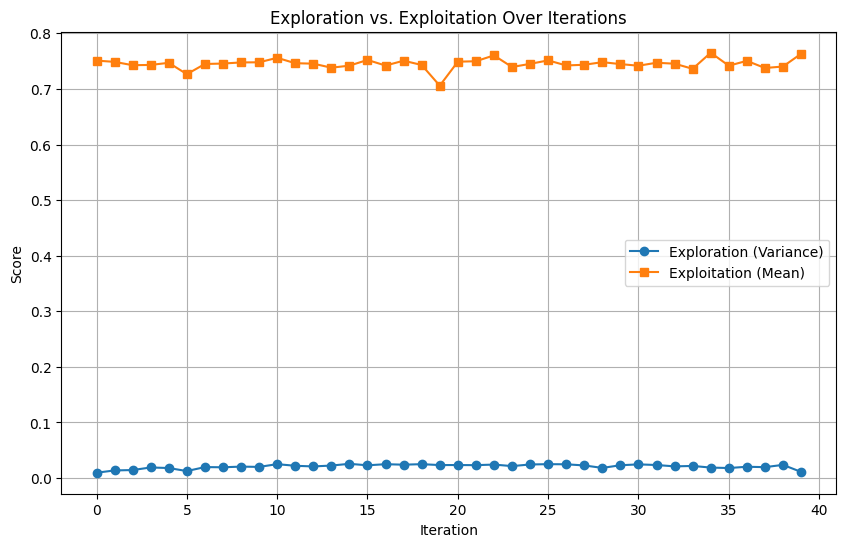

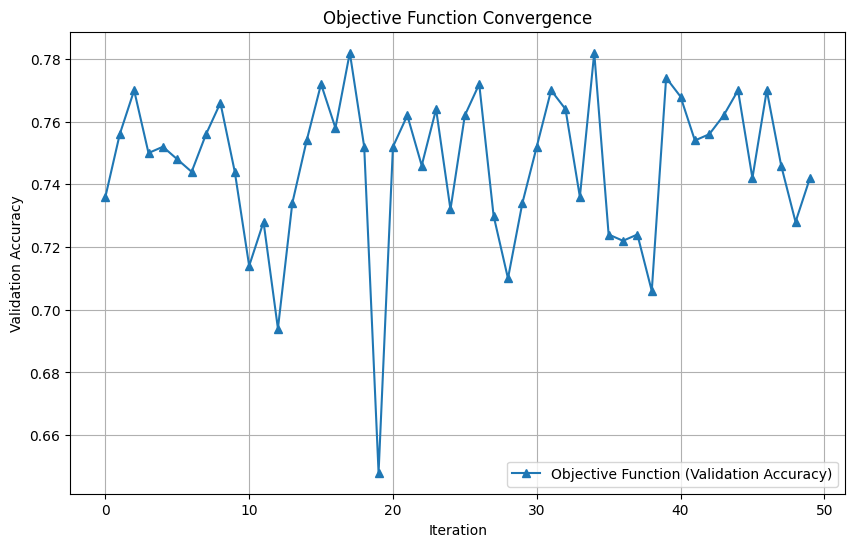

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Visualization of exploration vs exploitation
plt.figure(figsize=(10, 6))
plt.plot(range(len(exploration_scores)), exploration_scores, label="Exploration (Variance)", marker="o", linestyle="-")
plt.plot(range(len(exploitation_scores)), exploitation_scores, label="Exploitation (Mean)", marker="s", linestyle="-")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Exploration vs. Exploitation Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Objective function values over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), y, label="Objective Function (Validation Accuracy)", marker="^", linestyle="-")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Objective Function Convergence")
plt.legend()
plt.grid(True)
plt.show()

- the acquisition function balances exploring uncertain areas (high variance) and exploiting promising regions (high mean).  
- the objective function (validation accuracy) over iterations to observe convergence.

- orange: mean (μ(x)) predicted by the Gaussian Process  
The variance is very low throughout the process, indicating that the algorithm is mostly confident about the predictions and is not actively exploring new areas of the hyperparameter space.  
The mean appears to stabilize quickly (around iteration 5) and remains high. This suggests that the algorithm focuses on refining the search in regions where it has already identified promising configurations.  

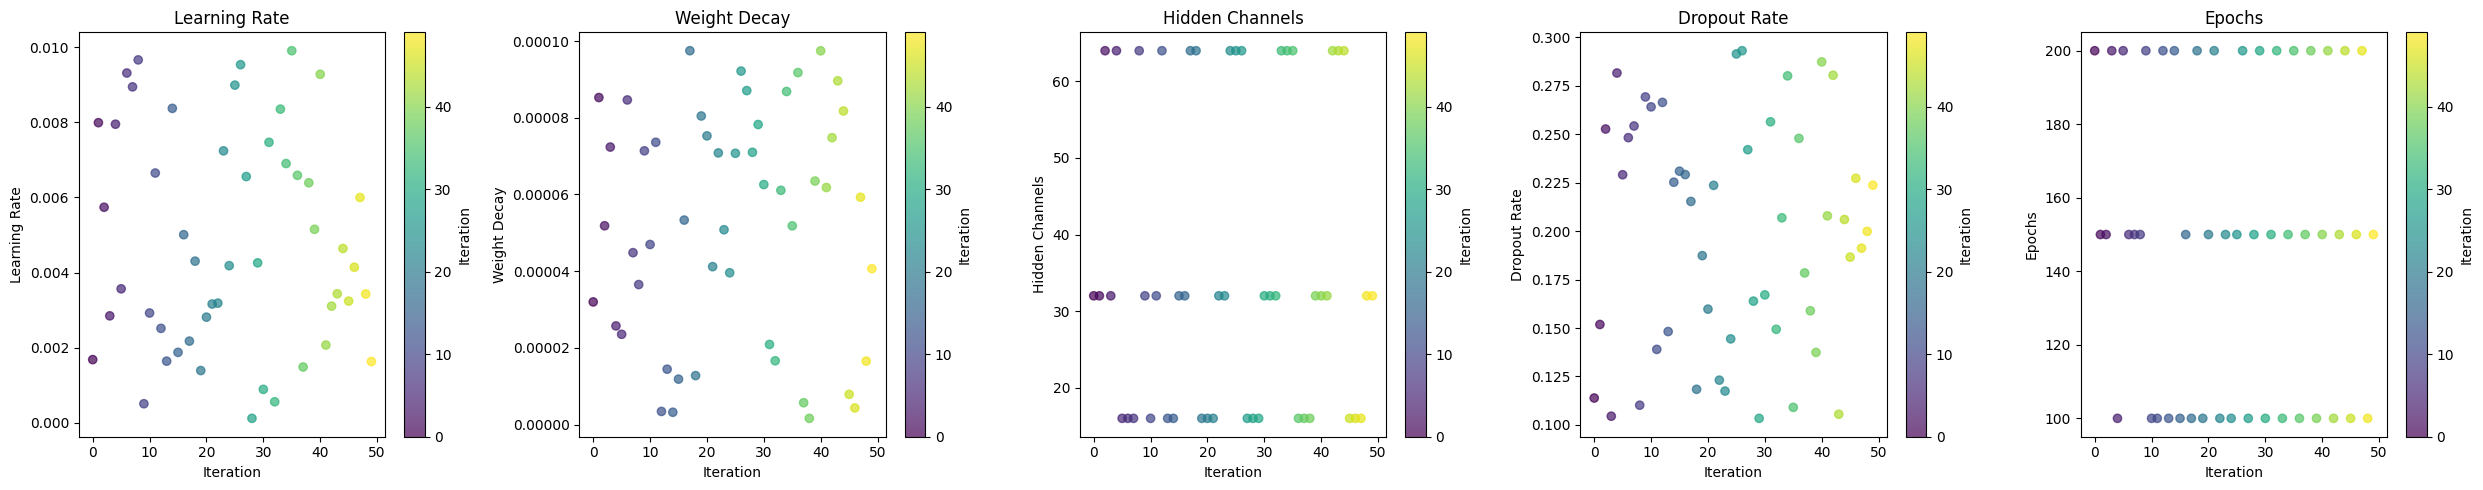

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_search_space(X, param_names):
    """
    Visualize the search space of sampled hyperparameters over iterations.
    Args:
        X: List of sampled hyperparameter configurations.
        param_names: List of parameter names for labeling.
    """
    X = np.array(X)
    num_params = X.shape[1]

    plt.figure(figsize=(25, 5))  # Adjust figure size for one-row layout

    for i in range(num_params):
        plt.subplot(1, num_params, i + 1)  # Arrange all plots in one row
        plt.scatter(range(len(X)), X[:, i], alpha=0.7, c=range(len(X)), cmap="viridis")
        plt.colorbar(label="Iteration")
        plt.title(f"{param_names[i]}")
        plt.xlabel("Iteration")
        plt.ylabel(param_names[i])

    plt.tight_layout()
    plt.show()

# Example usage
param_names = ["Learning Rate", "Weight Decay", "Hidden Channels", "Dropout Rate", "Epochs"]
visualize_search_space(X, param_names)


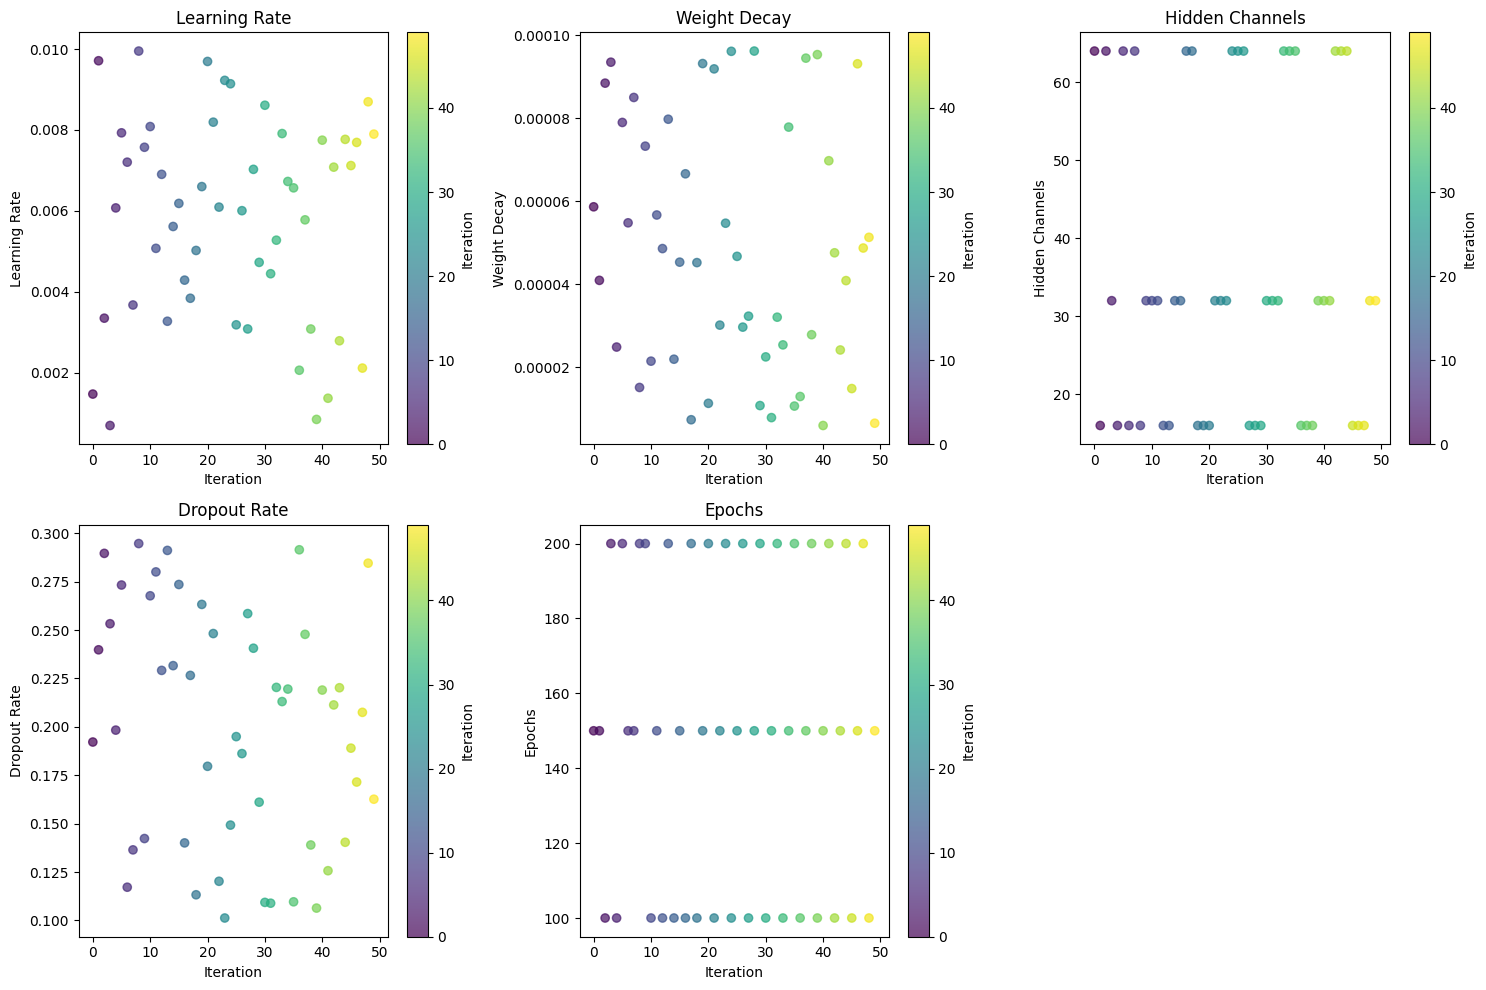

In [ ]:
  import matplotlib.pyplot as plt
  import numpy as np

  def visualize_search_space(X, param_names):
      """
      Visualize the search space of sampled hyperparameters over iterations.
      Args:
          X: List of sampled hyperparameter configurations.
          param_names: List of parameter names for labeling.
      """
      X = np.array(X)
      num_params = X.shape[1]

      plt.figure(figsize=(15, 10))

      for i in range(num_params):
          plt.subplot(2, (num_params + 1) // 2, i + 1)
          plt.scatter(range(len(X)), X[:, i], alpha=0.7, c=range(len(X)), cmap="viridis")
          plt.colorbar(label="Iteration")
          plt.title(f"{param_names[i]}")
          plt.xlabel("Iteration")
          plt.ylabel(param_names[i])

      plt.tight_layout()
      plt.show()

  param_names = ["Learning Rate", "Weight Decay", "Hidden Channels", "Dropout Rate", "Epochs"]
  visualize_search_space(X, param_names)


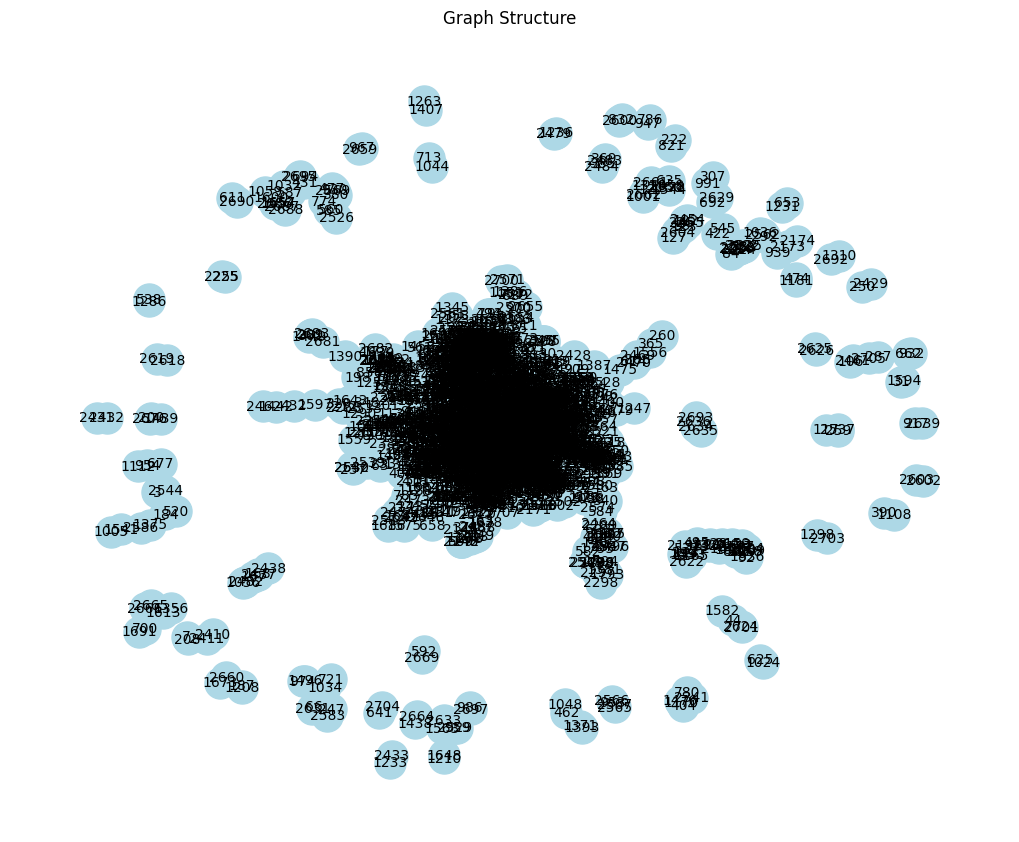

Number of nodes: 2708
Number of edges: 5278
Number of connected components: 78
Largest connected component size: 2485


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert the PyTorch Geometric data to a NetworkX graph
def visualize_graph(data, node_labels=True):
    """
    Visualize the graph structure and analyze its connectivity.
    Args:
        data: PyTorch Geometric data object (e.g., CORA dataset)
        node_labels: Whether to display node labels (default: True)
    """
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=True)  # Convert to undirected graph

    # Graph visualization
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization
    nx.draw(
        G,
        pos,
        with_labels=node_labels,
        node_color="lightblue",
        edge_color="gray",
        node_size=500,
        font_size=10,
    )
    plt.title("Graph Structure")
    plt.show()

    # Analyze graph connectivity
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    connected_components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Number of connected components: {connected_components}")
    print(f"Largest connected component size: {len(largest_cc)}")

visualize_graph(data)


first try with : random sample = 5, iter = 20 -> Best = 0.76  
2nd try with : random sample = 10, iter = 50, add penalty for same pair of parameter, scale kernel to length_scale_bounds=(1e-6, 1e3), reduce grp alpa to 1e-4 -> Best = 0.79

3rd try: reduce drop out (0.1, 0.3), add optimize metric training time, F1score, add hidden size 128, Use a logarithmic scale for learning rate search [1e-5, 1e-2]

In [ ]:
  # Bayesian Optimization Setup
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kernel = Matern(length_scale_bounds=(1e-6, 1e3), nu=2.5)  # Matern kernel for smooth
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, normalize_y=True)

n_iterations = 50
X = []  # Hyperparameter samples
y = []  # Composite metrics (optimization target)
val_accuracies = []  # To track validation accuracy
sampled_combinations = {}  # Track sampled combinations

for iteration in range(n_iterations):
    print(f"Iteration {iteration+1}/{n_iterations}")

    if iteration % 10 == 0 and len(X) > 5:
        # Reinitialize and refit the surrogate model
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, normalize_y=True)
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))

    if len(X) <= 10:
        # Random sampling for initial iterations
        next_sample = random_sample(param_space)
    else:
        # Optimize the acquisition function
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))
        next_sample = optimize_acquisition(gpr, param_space, sampled_combinations)

    # Evaluate the objective function
    val_acc, composite_metric = objective_function(next_sample)

    # Update sampled combinations for discrete parameters
    hidden_channels, epochs = next_sample[2], next_sample[4]
    sampled_combinations[(hidden_channels, epochs)] = sampled_combinations.get((hidden_channels, epochs), 0) + 1

    # Log the results
    X.append(next_sample)
    y.append(composite_metric)  # Use composite metric for optimization
    val_accuracies.append(val_acc)  # Track validation accuracy separately

    print(f"Iteration {iteration+1}, Params: {next_sample}, Val Acc: {val_acc:.4f}, Composite Metric: {composite_metric:.4f}")

# Best parameters based on the composite metric
best_idx = np.argmax(y)
best_params = X[best_idx]
best_composite_metric = y[best_idx]
best_val_acc = val_accuracies[best_idx]

print(f"Best Parameters: {best_params}")
print(f"Best Composite Metric: {best_composite_metric:.4f}")
print(f"Validation Accuracy of Best Parameters: {best_val_acc:.4f}")


Iteration 1/50
Iteration 1, Params: [0.0010481158167202447, 0.00041472684764992803, 64, 0.12655628649963174, 100], Val Acc: 0.7620, Composite Metric: 1.4778
Iteration 2/50
Iteration 2, Params: [0.005735233249211856, 0.0002559404400377507, 64, 0.2859151492873979, 150], Val Acc: 0.7620, Composite Metric: 1.4601
Iteration 3/50
Iteration 3, Params: [0.00020141724978023134, 0.0009799785711754017, 128, 0.10772302822044531, 100], Val Acc: 0.7580, Composite Metric: 1.4678
Iteration 4/50
Iteration 4, Params: [0.00845888259222618, 0.0008328800121139045, 32, 0.2532814439197242, 200], Val Acc: 0.7820, Composite Metric: 1.4937
Iteration 5/50
Iteration 5, Params: [0.005041977577259787, 0.0007480057245273619, 128, 0.2701704084189588, 100], Val Acc: 0.7540, Composite Metric: 1.4618
Iteration 6/50
Iteration 6, Params: [0.00538237402023782, 0.0008957867191431644, 16, 0.1039114019581569, 100], Val Acc: 0.7420, Composite Metric: 1.4544
Iteration 7/50
Iteration 7, Params: [0.006522764727233298, 0.000655497

###III, Random saerch





In [ ]:
import numpy as np
import random
import time

# Define the search space
param_space = {
    "learning_rate": (1e-4, 1e-2),
    "weight_decay": (1e-6, 1e-4),
    "hidden_channels": [16, 32, 64],
    "dropout_rate": (0.1, 0.3),
    "epochs": [100, 150, 200]
}

# Random search
def random_search(param_space, num_trials):
    best_metric = -float("inf")
    best_params = None
    best_val_acc = -float("inf")
    results = []
    start_time = time.time()

    for trial in range(num_trials):
        params = {
            "learning_rate": np.random.uniform(*param_space["learning_rate"]),
            "weight_decay": np.random.uniform(*param_space["weight_decay"]),
            "hidden_channels": random.choice(param_space["hidden_channels"]),
            "dropout_rate": np.random.uniform(*param_space["dropout_rate"]),
            "epochs": random.choice(param_space["epochs"])
        }

        val_acc, composite_metric = objective_function(list(params.values()))
        results.append({"params": params, "val_acc": val_acc, "composite_metric": composite_metric})

        print(f"Trial {trial+1}/{num_trials} - Params: {params}\n, Val Acc: {val_acc:.4f}, Composite Metric: {composite_metric:.4f}")

        if composite_metric > best_metric:
            best_metric = composite_metric
            best_params = params
            best_val_acc = val_acc

    training_time = time.time() - start_time
    print(f'Total run time: {training_time}')

    return best_params, best_metric, results

# Run random search
random_best_params, random_best_metric, random_results = random_search(param_space, num_trials=50)
print(f"Random Search Best Params: {random_best_params}")
print(f"Random Search Best Metric: {random_best_metric:.4f}")
print(f"Random Search Results: {random_results[-1]}")


Trial 1/50 - Params: {'learning_rate': 0.0026784115894529616, 'weight_decay': 6.307985702246506e-05, 'hidden_channels': 32, 'dropout_rate': 0.2722837060408406, 'epochs': 150}
, Val Acc: 0.7820, Composite Metric: 1.5129
Trial 2/50 - Params: {'learning_rate': 0.0027707735026412843, 'weight_decay': 4.556144142826278e-05, 'hidden_channels': 64, 'dropout_rate': 0.24797020345122925, 'epochs': 100}
, Val Acc: 0.7580, Composite Metric: 1.4784
Trial 3/50 - Params: {'learning_rate': 0.000912872308384494, 'weight_decay': 8.425511556613718e-05, 'hidden_channels': 16, 'dropout_rate': 0.17529792816374828, 'epochs': 150}
, Val Acc: 0.7660, Composite Metric: 1.4858
Trial 4/50 - Params: {'learning_rate': 0.00011322729800054447, 'weight_decay': 2.0893537131346523e-05, 'hidden_channels': 16, 'dropout_rate': 0.22040940405844728, 'epochs': 100}
, Val Acc: 0.2780, Composite Metric: 0.4539
Trial 5/50 - Params: {'learning_rate': 0.0015428094084384489, 'weight_decay': 6.655080261039322e-05, 'hidden_channels': 

In [ ]:
random_runtime = sum([r["composite_metric"] for r in random_results])  # Already measured total runtime
random_composite_metrics = [r["composite_metric"] for r in random_results]  # Extract composite metrics

# Package results
random_results_for_plot = {
    "composite_metrics": random_composite_metrics,
    "runtime": random_runtime,
}

print(f"random Search Best Params: {random_best_params}")
print(f"random Search Best Composite Metric: {random_best_metric:.4f}")

random Search Best Params: {'learning_rate': 0.004320020755114454, 'weight_decay': 3.001319426275442e-05, 'hidden_channels': 64, 'dropout_rate': 0.25693983642299173, 'epochs': 100}
random Search Best Composite Metric: 1.5285


Total run time: 214.66425204277039  
Random Search Best Params: {'learning_rate': 0.004320020755114454, 'weight_decay': 3.001319426275442e-05, 'hidden_channels': 64, 'dropout_rate': 0.25693983642299173, 'epochs': 100}  
Random Search Best Metric: 1.5285

In [ ]:
# start_time = time.time()
#training_time = time.time() - start_time
# print(f'Total run time: {training_time}')

In [ ]:
from itertools import product

# Grid search
def grid_search(param_space):
    best_metric = -float("inf")
    best_params = None
    results = []

    # Create the grid
    learning_rate = np.linspace(param_space["learning_rate"][0], param_space["learning_rate"][1], 4)
    weight_decay = np.linspace(param_space["weight_decay"][0], param_space["weight_decay"][1], 4)
    hidden_channels = param_space["hidden_channels"]
    dropout_rate = np.linspace(param_space["dropout_rate"][0], param_space["dropout_rate"][1], 4)
    epochs = param_space["epochs"]

    grid_size = len(learning_rate) * len(weight_decay) * len(hidden_channels) * len(dropout_rate) * len(epochs)
    print(f"Starting Grid Search with {grid_size} combinations...")

    start_time = time.time()

    for idx,combination in enumerate(product(learning_rate, weight_decay, hidden_channels, dropout_rate, epochs)):
        params = {
            "learning_rate": combination[0],
            "weight_decay": combination[1],
            "hidden_channels": combination[2],
            "dropout_rate": combination[3],
            "epochs": combination[4]
        }

        val_acc, composite_metric = objective_function(list(params.values()))
        results.append({"params": params, "val_acc": val_acc, "composite_metric": composite_metric})

        print(f"Combination {idx+1}/{grid_size} - Params: {params}, Val Acc: {val_acc:.4f}, Composite Metric: {composite_metric:.4f}")

        if composite_metric > best_metric:
            best_metric = composite_metric
            best_params = params

    training_time = time.time() - start_time
    print(f'Total run time: {training_time}')
    return best_params, best_metric, results

# Run grid search
grid_best_params, grid_best_metric, grid_results = grid_search(param_space)
print(f"Grid Search Best Params: {grid_best_params}")
print(f"Grid Search Best Metric: {grid_best_metric:.4f}")
print(f"Grid Search Results: {grid_results}")


Starting Grid Search with 576 combinations...
Combination 1/576 - Params: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'hidden_channels': 16, 'dropout_rate': 0.1, 'epochs': 100}, Val Acc: 0.2620, Composite Metric: 0.3695
Combination 2/576 - Params: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'hidden_channels': 16, 'dropout_rate': 0.1, 'epochs': 150}, Val Acc: 0.3140, Composite Metric: 0.5198
Combination 3/576 - Params: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'hidden_channels': 16, 'dropout_rate': 0.1, 'epochs': 200}, Val Acc: 0.4420, Composite Metric: 0.8106
Combination 4/576 - Params: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'hidden_channels': 16, 'dropout_rate': 0.16666666666666669, 'epochs': 100}, Val Acc: 0.1380, Composite Metric: 0.2462
Combination 5/576 - Params: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'hidden_channels': 16, 'dropout_rate': 0.16666666666666669, 'epochs': 150}, Val Acc: 0.4220, Composite Metric: 0.8123
Combination 6/576 - Params:

In [ ]:
# Run grid search
# grid_best_params, grid_best_metric, grid_results = grid_search(param_space)
grid_runtime = sum([r["composite_metric"] for r in grid_results])  # Already measured total runtime
grid_composite_metrics = [r["composite_metric"] for r in grid_results]  # Extract composite metrics

# Package results
grid_results_for_plot = {
    "composite_metrics": grid_composite_metrics,
    "runtime": grid_runtime
}

print(f"Grid Search Best Params: {grid_best_params}")
print(f"Grid Search Best Composite Metric: {grid_best_metric:.4f}")
print(f"runtime: {grid_runtime}")


Grid Search Best Params: {'learning_rate': 0.0034000000000000002, 'weight_decay': 6.7e-05, 'hidden_channels': 64, 'dropout_rate': 0.1, 'epochs': 100}
Grid Search Best Composite Metric: 1.5283
runtime: 779.7547351074896


Val Acc: 0.7820
Total run time: 2245.6857120990753
Grid Search Best Params: {'learning_rate': 0.0034000000000000002, 'weight_decay': 6.7e-05, 'hidden_channels': 64, 'dropout_rate': 0.1, 'epochs': 100}
Grid Search Best Metric: 1.5283

In [ ]:
# Bayesian results (use from your Bayesian Optimization loop)
# bayesian_best_params = best_params  # From the Bayesian loop
# bayesian_best_metric = best_composite_metric

# Print comparison
print("Comparison of Optimization Approaches:")
print(f"Bayesian Optimization Best Metric: {metric:.4f}")
print(f"Random Search Best Metric: {random_best_metric:.4f}")
print(f"Grid Search Best Metric: {grid_best_metric:.4f}")


Comparison of Optimization Approaches:
Bayesian Optimization Best Metric: 1.4345
Random Search Best Metric: 1.5285
Grid Search Best Metric: 1.5283


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import time

# Setup
scaler = StandardScaler()
kernel = Matern(length_scale_bounds=(1e-5, 1e3), nu=2.5)  # Matern kernel for smooth
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

n_iterations = 50
X = []  # Hyperparameter samples
y = []  # Objective function evaluations (validation accuracy)
composite_metrics = []  # Store composite metrics
sampled_combinations = {}

exploration_scores = []  # To track variance (exploration)
exploitation_scores = []  # To track mean (exploitation)

start_time = time.time()  # Start timing the Bayesian Optimization
for iteration in range(n_iterations):
    print(f"Iteration {iteration+1}/{n_iterations}")

    if iteration % 10 == 0 and len(X) > 5:
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))

    if len(X) < 10:
        # Random sample
        next_sample = random_sample(param_space)
    else:
        # Fit the surrogate model
        scaled_X = scaler.fit_transform(np.array(X))
        gpr.fit(scaled_X, np.array(y))

        # Optimize the acquisition function
        next_sample = optimize_acquisition(gpr, param_space, sampled_combinations)

        # Compute exploration and exploitation for the current sample
        mean, std = gpr.predict(scaler.transform([next_sample]), return_std=True)
        exploration_scores.append(std[0])  # Variance indicates exploration
        exploitation_scores.append(mean[0])  # Mean indicates exploitation

    # Evaluate the objective function
    val_acc, composite_metric = objective_function(next_sample)
    hidden_channels, epochs = next_sample[2], next_sample[4]
    sampled_combinations[(hidden_channels, epochs)] = sampled_combinations.get((hidden_channels, epochs), 0) + 1

    # Update datasets
    X.append(next_sample)
    y.append(val_acc)
    composite_metrics.append(composite_metric)

    # Print results for the current iteration
    print(f"Iteration {iteration+1}, Params: {next_sample}, Validation Acc: {val_acc:.4f}, Composite Metric: {composite_metric:.4f}")

# Calculate runtime
bayesian_runtime = time.time() - start_time
print(f"Bayesian Optimization Total Runtime: {bayesian_runtime:.2f} seconds")

# Best parameters
best_idx = np.argmax(y)
best_params = X[best_idx]
best_val_acc = y[best_idx]
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Package results for visualization
bayesian_results = {
    "composite_metrics": composite_metrics,
    "runtime": bayesian_runtime
}


Iteration 1/50
Iteration 1, Params: [0.0016836401621926115, 3.198590104000403e-05, 32, 0.11386199134945721, 200], Validation Acc: 0.7580, Composite Metric: 1.4430
Iteration 2/50
Iteration 2, Params: [0.007991292431252642, 8.52780222646451e-05, 32, 0.15182461897292038, 150], Validation Acc: 0.7500, Composite Metric: 1.4500
Iteration 3/50
Iteration 3, Params: [0.005739830687970651, 5.1840708015443527e-05, 64, 0.25272625408409277, 150], Validation Acc: 0.7560, Composite Metric: 1.4537
Iteration 4/50
Iteration 4, Params: [0.002848569358222826, 7.236391606456813e-05, 32, 0.1044837665345399, 200], Validation Acc: 0.7540, Composite Metric: 1.4460
Iteration 5/50
Iteration 5, Params: [0.00795073139022117, 2.573225602134431e-05, 64, 0.2816356943703139, 100], Validation Acc: 0.7420, Composite Metric: 1.4499
Iteration 6/50
Iteration 6, Params: [0.0035680888633758817, 2.353958972897635e-05, 16, 0.22912229451678479, 200], Validation Acc: 0.7400, Composite Metric: 1.4228
Iteration 7/50
Iteration 7, P

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 30, Params: [0.0042598886154295605, 7.824039522696667e-05, 16, 0.10337194630653189, 200], Validation Acc: 0.7260, Composite Metric: 1.3833
Iteration 31/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 31, Params: [0.0008915539297791095, 6.25917991617313e-05, 32, 0.1670897741598793, 100], Validation Acc: 0.7640, Composite Metric: 1.4900
Iteration 32/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 32, Params: [0.007468495227408398, 2.089702190958172e-05, 32, 0.2564459521053012, 150], Validation Acc: 0.7360, Composite Metric: 1.4211
Iteration 33/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 33, Params: [0.0005613743707456404, 1.663998636014763e-05, 32, 0.14933705373734768, 200], Validation Acc: 0.7580, Composite Metric: 1.4445
Iteration 34/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 34, Params: [0.008351772182527747, 6.108562536709288e-05, 64, 0.20688697203035517, 100], Validation Acc: 0.6940, Composite Metric: 1.3597
Iteration 35/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 35, Params: [0.006903303162346656, 8.685507559804428e-05, 64, 0.2801668169470998, 150], Validation Acc: 0.7580, Composite Metric: 1.4604
Iteration 36/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 36, Params: [0.009906895614568763, 5.182076288647412e-05, 64, 0.10904144241648568, 200], Validation Acc: 0.7400, Composite Metric: 1.4056
Iteration 37/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 37, Params: [0.006589747334766747, 9.178163888224239e-05, 16, 0.2478938452931405, 100], Validation Acc: 0.7300, Composite Metric: 1.4286
Iteration 38/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 38, Params: [0.0014867375721417159, 5.70414539935665e-06, 16, 0.1784319739041534, 150], Validation Acc: 0.7460, Composite Metric: 1.4388
Iteration 39/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 39, Params: [0.006391307372499694, 1.6305516908680876e-06, 16, 0.1588932834845723, 200], Validation Acc: 0.7740, Composite Metric: 1.4813
Iteration 40/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 40, Params: [0.005152436539420574, 6.350056496376182e-05, 32, 0.13739149355046273, 100], Validation Acc: 0.7520, Composite Metric: 1.4668
Iteration 41/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 41, Params: [0.009280135583675506, 9.745567333837278e-05, 32, 0.2873776637177633, 150], Validation Acc: 0.7700, Composite Metric: 1.4828
Iteration 42/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 42, Params: [0.00207162053736529, 6.181517928199362e-05, 32, 0.2079057489118685, 200], Validation Acc: 0.7700, Composite Metric: 1.4715
Iteration 43/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 43, Params: [0.00310739099704988, 7.481009222216366e-05, 64, 0.2804967662185578, 100], Validation Acc: 0.7620, Composite Metric: 1.4845
Iteration 44/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 44, Params: [0.0034362552633303914, 8.963537415085611e-05, 64, 0.10550853743722746, 150], Validation Acc: 0.7660, Composite Metric: 1.4776
Iteration 45/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 45, Params: [0.004641726837923573, 8.17703034038146e-05, 64, 0.2060173536558692, 200], Validation Acc: 0.7740, Composite Metric: 1.4744
Iteration 46/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 46, Params: [0.003241634966533298, 7.887410988193659e-06, 16, 0.18660380337869092, 100], Validation Acc: 0.7320, Composite Metric: 1.4453
Iteration 47/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 47, Params: [0.0041429300855967514, 4.338607770986656e-06, 16, 0.2273068469696061, 150], Validation Acc: 0.7080, Composite Metric: 1.3476
Iteration 48/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 48, Params: [0.005998510345284188, 5.927865423464015e-05, 16, 0.19121342541943762, 200], Validation Acc: 0.7540, Composite Metric: 1.4361
Iteration 49/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 49, Params: [0.0034312976159884957, 1.655670448466438e-05, 32, 0.19989585244457375, 100], Validation Acc: 0.7700, Composite Metric: 1.5005
Iteration 50/50


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 50, Params: [0.0016327239825203396, 4.065555169153887e-05, 32, 0.22373525211189582, 150], Validation Acc: 0.7520, Composite Metric: 1.4492
Bayesian Optimization Total Runtime: 213.28 seconds
Best Parameters: [0.006391307372499694, 1.6305516908680876e-06, 16, 0.1588932834845723, 200]
Best Validation Accuracy: 0.7740


Total run time: 206.2922010421753
Best Parameters: [0.001370859986653613, 6.97470491828062e-05, 32, 0.1256844319875672, 200]
1.5145
Best Validation Accuracy: 0.7920

Val Acc: 0.7820 Total run time: 2245.6857120990753 Grid Search Best Params: {'learning_rate': 0.0034000000000000002, 'weight_decay': 6.7e-05, 'hidden_channels': 64, 'dropout_rate': 0.1, 'epochs': 100} Grid Search Best Metric: 1.5283

Total run time: 214.66425204277039  
Random Search Best Params: {'learning_rate': 0.004320020755114454, 'weight_decay': 3.001319426275442e-05, 'hidden_channels': 64, 'dropout_rate': 0.25693983642299173, 'epochs': 100}  
Random Search Best Metric: 1.5285

In [ ]:
import matplotlib.pyplot as plt
num_trials = 50
grid_size = 576
def plot_comparison(random_results, grid_results, bayesian_results):
    # Extract metrics for plotting
    random_metrics = [r["composite_metric"] for r in random_results]
    grid_metrics = [g["composite_metric"] for g in grid_results]
    bayesian_metrics = bayesian_results["composite_metrics"]

    # 1. Line Plot: Composite Metric over Iterations
    plt.figure(figsize=(10, 6))
    plt.plot(random_metrics, label="Random Search", marker="o")
    plt.plot(grid_metrics, label="Grid Search", marker="s")
    plt.plot(bayesian_metrics, label="Bayesian Optimization", marker="^")
    plt.xlabel("Iteration/Trial")
    plt.ylabel("Composite Metric")
    plt.title("Composite Metric Over Iterations")
    plt.legend()
    plt.show()

    # 2. Bar Plot: Best Composite Metric
    best_metrics = [
        max(random_metrics),
        max(grid_metrics),
        max(bayesian_metrics),
    ]
    methods = ["Random Search", "Grid Search", "Bayesian Optimization"]
    plt.figure(figsize=(8, 5))
    plt.bar(methods, best_metrics, color=["blue", "green", "orange"])
    plt.ylabel("Best Composite Metric")
    plt.title("Best Composite Metric by Method")
    plt.show()

    # 3. Time vs. Composite Metric
    runtimes = [random_runtime, grid_runtime, bayesian_runtime]
    plt.figure(figsize=(8, 5))
    plt.bar(methods, runtimes, color=["blue", "green", "orange"])
    plt.ylabel("Total Runtime (seconds)")
    plt.title("Runtime Comparison by Method")
    plt.show()

random_results = {
    "composite_metrics": [r["composite_metric"] for r in num_trials],
    "runtime": random_runtime
}

grid_results = {
    "composite_metrics": [g["composite_metric"] for g in grid_size],
    "runtime": grid_runtime
}

# Plot comparisons
plot_comparison(random_results, grid_results, bayesian_results)


TypeError: 'int' object is not iterable

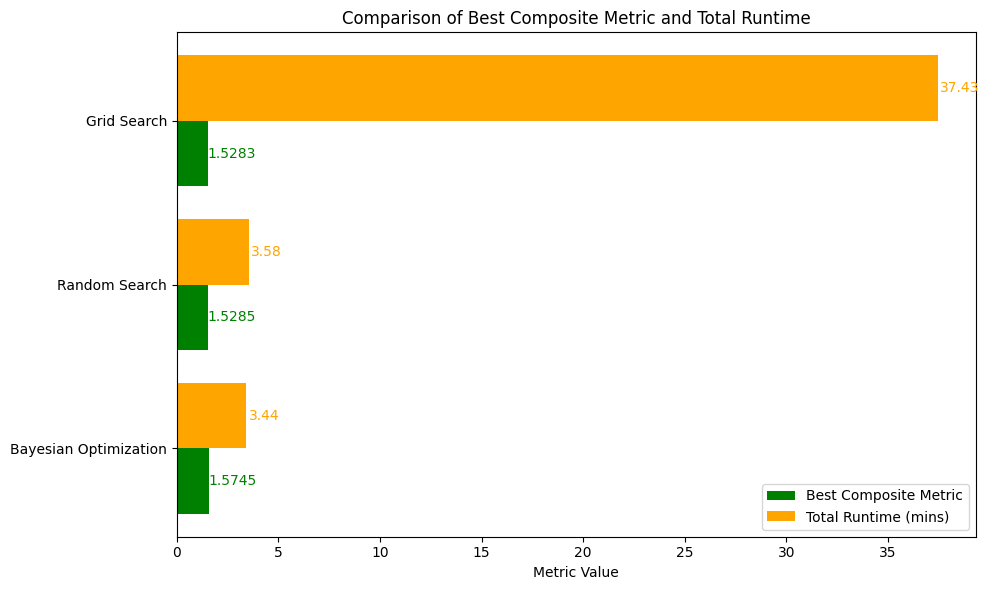

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ["Bayesian Optimization", "Random Search", "Grid Search"]
best_composite_metrics = [1.5745, 1.5285, 1.5283]
total_runtimes = [float(206.29/60), float(214.66/60), float(2245.69/60)]

# Create bar positions
y = np.arange(len(methods))  # Positions for the methods
bar_height = 0.4  # Height of each bar

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Best Composite Metric
ax.barh(y - bar_height / 2, best_composite_metrics, bar_height, color="green", label="Best Composite Metric")

# Plot Total Runtime
ax.barh(y + bar_height / 2, total_runtimes, bar_height, color="orange", label="Total Runtime (mins)")

# Add labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(methods)
ax.set_xlabel("Metric Value")
ax.set_title("Comparison of Best Composite Metric and Total Runtime")
ax.legend()

# Add value annotations
for i in range(len(methods)):
    ax.text(best_composite_metrics[i] + 0.01, y[i] - bar_height / 2, f"{best_composite_metrics[i]:.4f}", va="center", color="green")
    ax.text(total_runtimes[i] + 0.1, y[i] + bar_height / 2, f"{total_runtimes[i]:.2f}", va="center", color="orange")

# Show plot
plt.tight_layout()
plt.show()
